# Basic Example

-------------------

In this example, we are going to cover the basic workflow 
to turn a DEM into a full mesh.

The basic workflow follows this pattern:

* Import the DEM
* Perform watershed delineation
* Verify that feature looks accurate
* Construct the surface mesh
* Construct the layered mesh
* Define facesets
* Save the mesh


In [1]:
import tinerator as tin
print(tin.VERSION)

v0.3.1


## Importing the DEM

Methods of import are found in the submodule `tinerator.load`. Some of these are:

* `from_file`: load from a locally-stored file
* `from_matrix`: initialize from a Numpy matrix
* `from_coordinates`: download and initialize from a longitude / latitude bounding box
* `from_shapefile`: download and initialize from a shapefile

In [2]:
my_dem = tin.load.from_file('data/dem.asc')

[00:19:43 -            from_file()] INFO - Reading DEM: data/dem.asc


[00:19:45 -             plot_dem()] INFO - Plotting DEM


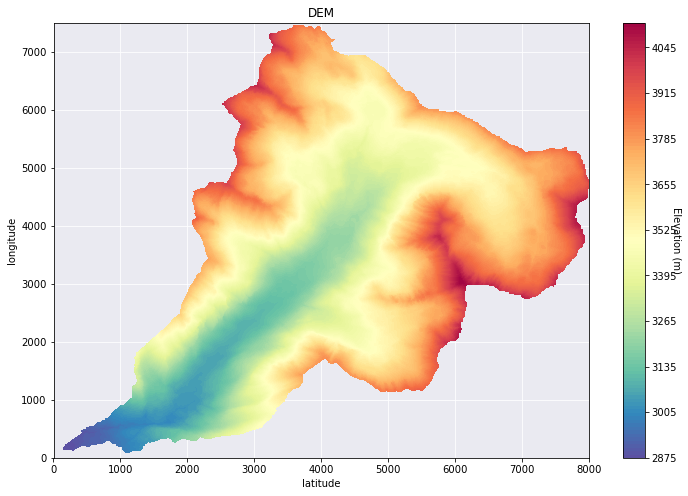

In [3]:
# View the DEM
tin.plot.plot_dem(my_dem) # alternately, you can call `my_dem.plot_dem()`

# 2. Performing Watershed Delineation

In order to construct a dynamically refined TIN, watershed delineation is performed to capture a river feature for selective refinement around.

This is done with the method

    my_dem.watershed_delineation(threshold:float,method:str='D8')
    
It is difficult to initially tell what the threshold value should be.

Before performing delineation, then, we can preview what feature would be generated:

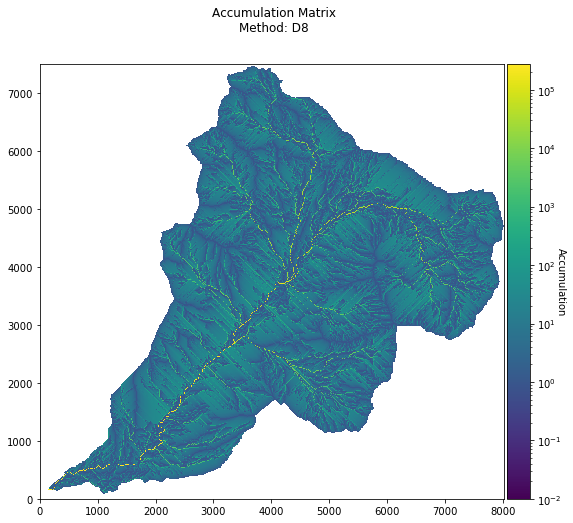

In [4]:
_ = tin.plot.preview_accumulation(my_dem)

Note that the feature appears around `1e4`. This will be our threshold value.

In [6]:
# Note - the threhold value `None` can *only* be used
# in `interactive` mode!
# my_dem.watershed_delineation(None,interactive=True)
my_dem.watershed_delineation(threshold = 1e4,interactive=True)

interactive(children=(FloatSlider(value=10000.0, description='threshold', max=277966.0, min=-1.0, step=2779.67…

# Construct the Surface Mesh

Now that we are satisfied with the river feature, we can build the surface mesh.

* `DEM.build_refined_triplane(min_edge,max_edge)` - builds a surface mesh refined around a feature captured by watershed delineation, with triangle edge lengths between `min_edge` and `max_edge` size
* `DEM.build_uniform_triplane(edge_length)` - builds a surface mesh with uniform triangles, of edge length `edge_length`

In [7]:
# Again, None can only be used in interactive mode
my_dem.build_refined_triplane(None,None,interactive=True)

interactive(children=(FloatRangeSlider(value=(0.0, 160.2), continuous_update=False, description='Edge Lengths:…

## Visualizing the Surface Mesh

We can then visualize the mesh, with full 3D interactivity, using `vtki` (press `w` to switch to wireframe mode):

In [8]:
import pyvista

outfile = 'surface_mesh.exo'
tin.dump.to_exodus(my_dem,outfile,mesh='surface')
pyvista.read(outfile).plot()

[00:23:25 -            to_exodus()] INFO - Wrote Exodus mesh to: "surface_mesh.exo"


VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

# Creating a Layered Mesh

We can then move to creating a stacked (layered) mesh.

The syntax is:

```python
DEM.build_layered_mesh(layers,matids:list=None)
```

Creating a stacked mesh requires only one argument: a list of depths to extrude. The number of layers created will be equal to the number of elements in the list.

For example, let's say that we want four layers: the first layer should be 10 meters thick, the second 20 meters, the third 30 meters, and the fourth 40 meters.

This would be represented as:

```python
depths = [10.,20.,30.,40.]
```

We can also assign material ID values to the layers, using another list of equal length.

```python
mat_ids = [1,4,2,1]
```

Note that material IDs must be integer-based.

In [9]:
depths = [10.,20.,30.,40.]
mat_ids = [1,4,2,1]

my_dem.build_layered_mesh(depths,matids=mat_ids)

[00:28:28 -        _stacked_mesh()] INFO - Stacking 4 layers
[00:28:28 -        _stacked_mesh()] INFO - Adding layer 1 with thickness 0.0
[00:28:29 -        _stacked_mesh()] INFO - Adding layer 2 with thickness 10.0
[00:28:30 -        _stacked_mesh()] INFO - Adding layer 3 with thickness 20.0
[00:28:31 -        _stacked_mesh()] INFO - Adding layer 4 with thickness 30.0
[00:28:32 -        _stacked_mesh()] INFO - Adding layer 5 with thickness 40.0
[00:28:33 -        _stacked_mesh()] INFO - Adding volume to layers


mo3

### Visualizing

In a similar fashion to the surface mesh, we can visualize the layered mesh as:

In [10]:
import pyvista

outfile = 'stacked_mesh.exo'
tin.dump.to_exodus(my_dem,outfile,mesh='stacked')
pyvista.read(outfile).plot()

[00:28:41 -            to_exodus()] INFO - Wrote Exodus mesh to: "stacked_mesh.exo"


VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

# Facesets

TINerator has multiple methods for faceset generation, found in the `tinerator.facesets` submodule.

These are:

* `tinerator.facesets.basic`: can create top surface, bottom surface, and/or side surface facesets
* `tinerator.facesets.from_elevations`: creates top-surface facesets, discretized by elevation values
* `tinerator.facesets.sidesets`: creates side-surface facesets, discretized by clockwise [x,y] values

These faceset objects can be combined to create more complex facesets. 

In this example, however, we will only focus on basic facesets.

In [11]:
fs_basic = tin.facesets.basic(has_top=True,has_bottom=True,has_sides=True)

tin.dump.to_exodus(my_dem,'final_mesh.exo',facesets=fs_basic)

[00:29:32 -       write_facesets()] INFO - Preparing sidesets...
[00:29:39 -       __driver_naive()] INFO - Generating top faceset
[00:29:40 -       __driver_naive()] INFO - Generating bottom faceset
[00:29:41 -       __driver_naive()] INFO - Generating sides faceset
[00:29:42 -            to_exodus()] INFO - Wrote Exodus mesh (of type: prism, with facesets: 3) to: "final_mesh.exo"


### Visualizing

We can visualize the sidesets only through:

In [12]:
import pyvista

pyvista.read('final_mesh.exo')['Side Sets'].plot()

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

# Conclusion

This has been a basic workflow for TINerator. More advanced capabilities can be found in other Jupyter notebooks in this directory, or through the API on the [TINerator homepage](https://raw.githack.com/lanl/LaGriT/tinerator/html/index.html).